In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from scipy import special
from scipy.spatial import distance
import seaborn as sns
from sklearn import metrics
import tqdm

from scripture_graph import graph_lib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
digraph = nx.read_graphml('../../../scripture_graph.graphml')
print(digraph.number_of_nodes(), digraph.number_of_edges())
graph_lib.remove_topic_nodes(digraph)
print(digraph.number_of_nodes(), digraph.number_of_edges())
graph = digraph.to_undirected()
print(graph.number_of_nodes(), graph.number_of_edges())

48566 183072
41995 45985
41995 26946


In [3]:
# nx.jaccard_coefficient is too slow; we can roll our own with the adjacency matrix.
possible = special.comb(graph.number_of_nodes(), 2, exact=True) - graph.number_of_nodes()
print(graph.number_of_edges(), possible, graph.number_of_edges() / possible * 100)

26946 881727020 0.00305604789110353


In [4]:
a = nx.adjacency_matrix(graph)
type(a)

scipy.sparse.csr.csr_matrix

In [5]:
# What is the average number of connections?
total = a.sum(axis=1)
print(np.mean(total), np.median(total))
# now without the singletons
print(np.mean(total[total > 0]), np.median(total[total > 0]))

1.2832956304321943 [[ 0.  0.  0. ...  2. 11.  3.]]
2.7284325637910083 [[ 1.  1.  1. ...  2. 11.  3.]]


In [6]:
# scipy jaccard sets the distance to zero when there are no common neighbors
def jaccard(a):
    ab = a @ a.T
    aa = a.sum(axis=1)
    bb = aa.T
    return ab / (aa + bb - ab)

In [7]:
%%time
s = jaccard(a)
s = np.nan_to_num(s, copy=False)
s[np.diag_indices_from(s)] = 0
print(s.shape)

/Users/kearnes/miniconda3/lib/python3.8/site-packages/scipy/sparse/base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


(41995, 41995)
CPU times: user 59.7 s, sys: 3min 5s, total: 4min 5s
Wall time: 6min


In [9]:
print(s.shape, (s > 0).sum())

(41995, 41995) 190494


In [78]:
%%time
nodes = np.asarray(graph.nodes())
mask = np.where(s > 0)
rows = []
for i, j in zip(*mask):
    order = sorted([nodes[i], nodes[j]])
    a = set([n[1] for n in graph.edges(order[0])])
    b = set([n[1] for n in graph.edges(order[1])])
    rows.append({
        'a': order[0], 
        'b': order[1], 
        'jaccard': s[i, j], 
        'intersection': len(a & b), 
        'union': len(a | b),
    })
df = pd.DataFrame(rows)
print(df.shape)
df = df.drop_duplicates(['a', 'b'])
print(df.shape)
# Annotate connections that already exist.
keep = []
for row in df.itertuples():
    try:
        graph.edges[(row.a, row.b)]
        keep.append(False)
    except KeyError:
        keep.append(True)
keep = np.asarray(keep)
df.loc[keep, 'exists'] = False
df.loc[~keep, 'exists'] = True
df['exists'] = df.exists.values.astype(bool)
df.head()

(190494, 5)
(95247, 5)
CPU times: user 12.9 s, sys: 9.29 s, total: 22.2 s
Wall time: 27.4 s


,a,b,jaccard,intersection,union,exists
0,1 Chr. 1:3,Moses 7:52,0.333333,1,3,False
1,1 Chr. 1:4,1 Chr. 1:8,0.500000,1,2,False
2,1 Chr. 1:4,Gen. 5:32,0.166667,1,6,False
3,1 Chr. 1:4,Gen. 8:16,0.333333,1,3,False
4,1 Chr. 1:4,Gen. 9:18,0.333333,1,3,False


In [79]:
df.shape[0] / possible * 100

0.010802322923028943

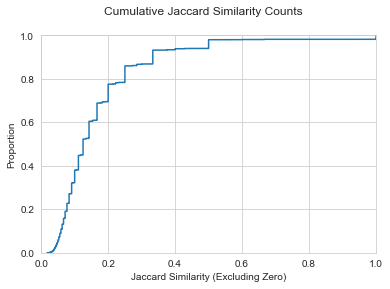

In [80]:
sns.set_style('whitegrid')
fig, ax = subplots()
sns.ecdfplot(data=df, x='jaccard', ax=ax)
suptitle('Cumulative Jaccard Similarity Counts')
ax.set_xlabel('Jaccard Similarity (Excluding Zero)')
ax.set_xlim(0, 1)
fig.savefig('jaccard-cdf.png', dpi=300, bbox_inches='tight')

<AxesSubplot:xlabel='intersection', ylabel='jaccard'>

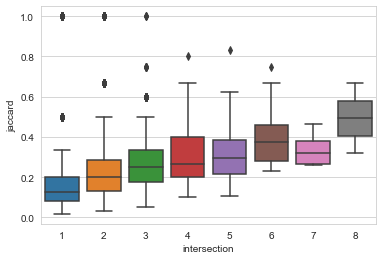

In [81]:
sns.boxplot(data=df, x='intersection', y='jaccard')

<AxesSubplot:xlabel='intersection', ylabel='union'>

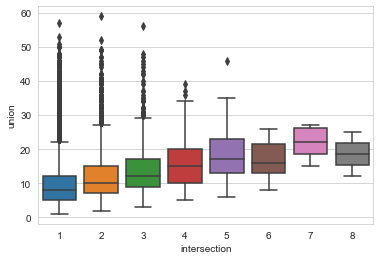

In [82]:
sns.boxplot(data=df, x='intersection', y='union')

In [83]:
df.sort_values('intersection', ascending=False)

,a,b,jaccard,intersection,union,exists
136840,D&C 18:26,D&C 90:9,0.666667,8,12,True
124485,D&C 101:7,Mosiah 21:15,0.320000,8,25,True
156269,D&C 8:3,Mosiah 7:19,0.259259,7,27,True
104998,3 Ne. 25:1,D&C 29:9,0.269231,7,26,True
126913,D&C 107:33,D&C 19:27,0.333333,7,21,True
...,...,...,...,...,...,...
39270,Alma 41:11,Isa. 26:11,0.142857,1,7,False
39269,Alma 11:39,Isa. 26:11,0.076923,1,13,False
39268,2 Ne. 26:12,Isa. 26:11,0.066667,1,15,False
39267,1 Ne. 19:10,Isa. 26:11,0.027778,1,36,False


In [84]:
df.sort_values('union', ascending=False)

,a,b,jaccard,intersection,union,exists
86512,1 Ne. 19:10,2 Ne. 25:20,0.033898,2,59,True
81230,1 Ne. 19:10,1 Ne. 1:4,0.017544,1,57,False
86606,1 Ne. 19:10,Mosiah 7:19,0.053571,3,56,True
86517,1 Ne. 19:10,2 Ne. 31:21,0.018868,1,53,False
86601,1 Ne. 19:10,Mosiah 3:5,0.038462,2,52,False
...,...,...,...,...,...,...
93006,2 Ne. 21:6,2 Ne. 30:12,1.000000,1,1,False
166668,Hel. 1:30,Hel. 4:8,1.000000,1,1,False
166669,Hel. 11:24,Hel. 1:32,1.000000,1,1,False
143866,D&C 41:3,D&C 58:23,1.000000,1,1,False


In [85]:
df.sort_values('jaccard', ascending=False)

,a,b,jaccard,intersection,union,exists
105942,3 Ne. 28:15,Ether 3:8,1.000000,1,1,False
19586,3 Ne. 28:35,Deut. 8:11,1.000000,1,1,False
5224,1 Sam. 12:24,Neh. 12:43,1.000000,1,1,False
43424,2 Ne. 18:17,Isa. 64:7,1.000000,1,1,False
43519,Isa. 65:10,Josh. 7:26,1.000000,1,1,False
...,...,...,...,...,...,...
81914,1 Ne. 10:12,1 Ne. 19:10,0.020000,1,50,False
136483,D&C 17:1,Mosiah 7:19,0.020000,1,50,False
86555,1 Ne. 19:10,D&C 19:27,0.019608,1,51,False
86517,1 Ne. 19:10,2 Ne. 31:21,0.018868,1,53,False


In [86]:
df[df.jaccard == 1].sort_values('intersection', ascending=False)

,a,b,jaccard,intersection,union,exists
19103,Deut. 5:17,Matt. 5:21,1.0,3,3,False
9028,2 Kgs. 14:24,2 Kgs. 15:9,1.0,3,3,False
43815,2 Ne. 18:6,Isa. 8:6,1.0,3,3,False
39001,D&C 88:105,Isa. 21:9,1.0,2,2,False
31356,1 Ne. 20:10,Gen. 15:13,1.0,2,2,False
...,...,...,...,...,...,...
20796,Esth. 5:9,Prov. 27:3,1.0,1,1,False
20795,Esth. 5:6,Esth. 9:12,1.0,1,1,False
20794,Esth. 5:2,Esth. 8:4,1.0,1,1,False
20777,Alma 47:22,Esth. 3:2,1.0,1,1,False


In [87]:
df[df.jaccard == 1].intersection.value_counts()

1    1689
2      31
3       3
Name: intersection, dtype: int64

In [88]:
df[df.jaccard == 1].exists.value_counts()

False    1723
Name: exists, dtype: int64

In [89]:
# singletons: no outgoing or incoming edges
num_singletons = 0
for node in graph.nodes:
    if not graph.edges(node):
        num_singletons += 1
print(num_singletons, graph.number_of_nodes(), num_singletons / graph.number_of_nodes())

22243 41995 0.5296582926538874


In [92]:
mask = (df.intersection > 1) & (df.jaccard < 1) & (~df.exists)
df[mask].sort_values(['intersection', 'jaccard'], ascending=False)

,a,b,jaccard,intersection,union,exists
53085,Josh. 2:10,Neh. 9:11,0.600000,6,10,False
110447,Alma 11:39,Mosiah 7:27,0.272727,6,22,False
97962,2 Ne. 33:13,Morm. 9:30,0.833333,5,6,False
56952,D&C 60:15,Luke 10:11,0.625000,5,8,False
60866,D&C 24:15,Matt. 10:14,0.555556,5,9,False
...,...,...,...,...,...,...
86562,1 Ne. 19:10,D&C 8:3,0.044444,2,45,False
86594,1 Ne. 19:10,Mosiah 15:2,0.044444,2,45,False
93960,2 Ne. 25:20,Mosiah 7:19,0.043478,2,46,False
81724,1 Ne. 10:3,1 Ne. 19:10,0.040816,2,49,False


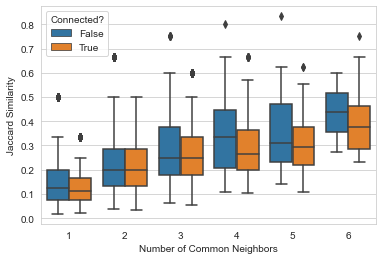

In [99]:
fig, ax = subplots()
mask = (df.jaccard < 1) & (df.intersection <= 6)
df['Connected?'] = df.exists
sns.boxplot(data=df[mask], x='intersection', y='jaccard', hue='Connected?', ax=ax)
ax.set_ylabel('Jaccard Similarity')
ax.set_xlabel('Number of Common Neighbors')
fig.savefig('jaccard-box.png', dpi=300, bbox_inches='tight')

In [101]:
df[df.intersection == 3]

,a,b,jaccard,intersection,union,exists,Connected?
206,1 Chr. 16:8,Alma 37:37,0.150000,3,20,True,True
209,1 Chr. 16:8,D&C 46:32,0.230769,3,13,True,True
210,1 Chr. 16:8,D&C 59:7,0.230769,3,13,False,False
1091,1 Chr. 9:3,2 Chr. 15:9,0.750000,3,4,False,False
1165,1 Cor. 1:10,3 Ne. 11:28,0.272727,3,11,True,True
...,...,...,...,...,...,...,...
187043,Mosiah 28:11,Mosiah 8:9,0.500000,3,6,False,False
188872,Mosiah 7:6,Mosiah 9:1,0.272727,3,11,True,True
188874,Mosiah 7:6,Omni 1:12,0.200000,3,15,True,True
189453,Mosiah 8:13,Omni 1:20,0.187500,3,16,True,True
